In [1]:
!pip install -U scikit-learn

In [2]:
# CPU specs
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [3]:
# univariate approach with WMA-LSTM and WMA-GRU
# import all needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from keras.callbacks import EarlyStopping

from time import perf_counter

import io

In [4]:
from google.colab import files

uploaded = files.upload()

Saving Import-1993-Feb2022.xlsx to Import-1993-Feb2022.xlsx


In [5]:
# <<INPUT>> file name
myDat = "Import-1993-Feb2022"

# <<INPUT>> test size [0 - 1]
testSize = 0.2

# load data
data = pd.read_excel(io.BytesIO(uploaded[myDat + '.xlsx']), index_col=0)

# check the first 5 rows
data.head()

,Oil and Gas,Non-Oil and Gas,Unnamed: 3,Unnamed: 4
Period,,,,
Jan 1993,132.2,2010.9,NaN,Diolah dari dokumen kepabeanan Ditjen Bea dan ...
Feb 1993,154.4,1861.5,NaN,Nilai impor adalah nilai Cost Insurance Freigh...
Mar 1993,112.1,2079.1,NaN,Angka Februari 2022 adalah angka tetap
Apr 1993,142.8,2092.0,NaN,Angka tahun 2022 merupakan nilai tetap Januari...
May 1993,153.8,1999.7,NaN,https://www.bps.go.id/indicator/8/1754/1/nilai...


In [6]:
# check the last 5 rows
data[-5:]

,Oil and Gas,Non-Oil and Gas,Unnamed: 3,Unnamed: 4
Period,,,,
Oct 2021,1898.1,14395.5,NaN,NaN
Nov 2021,3025.0,16303.2,NaN,NaN
Dec 2021,3377.8,17974.2,NaN,NaN
Jan 2022,2229.2,15981.9,NaN,NaN
Feb 2022,2902.3,13736.1,NaN,NaN


In [7]:
# used the first three columns
data = data.iloc[:,:2]
data.head()

,Oil and Gas,Non-Oil and Gas
Period,,
Jan 1993,132.2,2010.9
Feb 1993,154.4,1861.5
Mar 1993,112.1,2079.1
Apr 1993,142.8,2092.0
May 1993,153.8,1999.7


In [8]:
# show the processed data length
print("Data length: {}".format(len(data)))

Data length: 350


In [9]:
# check for missing data if available
data.isnull().sum()

Oil and Gas        0
Non-Oil and Gas    0
dtype: int64

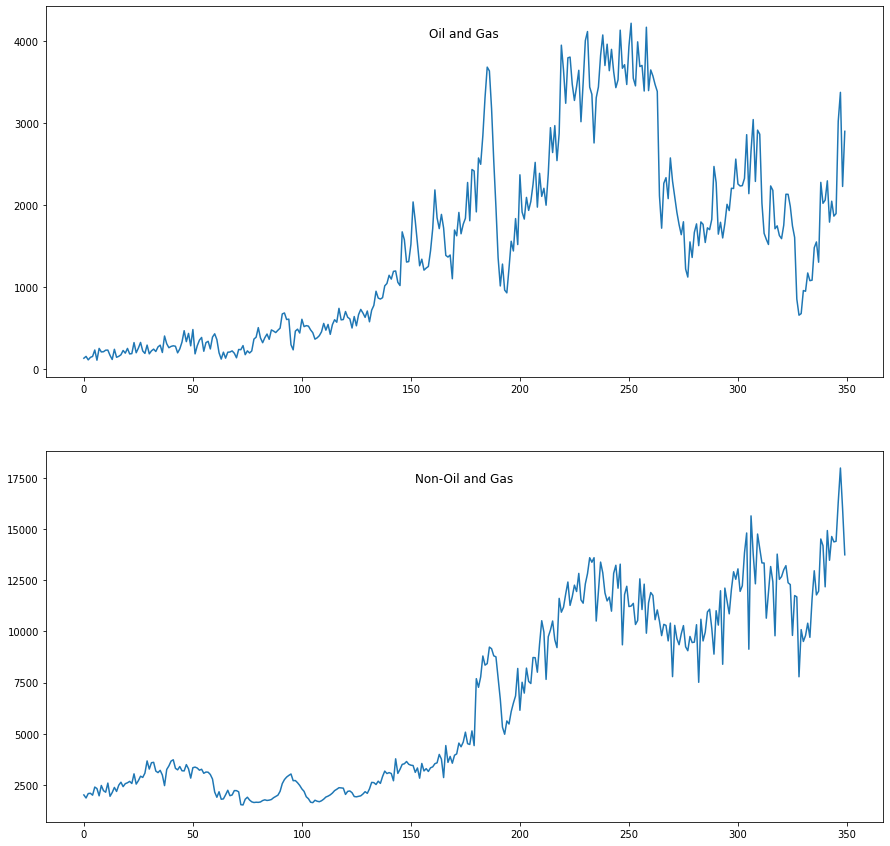

In [10]:
# basic information
values = data.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
plt.figure(figsize=(15,15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.9)
    i += 1
plt.show()

In [11]:
# data summary
data.describe()

,Oil and Gas,Non-Oil and Gas
count,350.000000,350.000000
mean,1515.112000,6679.183429
std,1161.049468,4433.731597
min,108.200000,1522.300000
25%,431.425000,2578.400000
50%,1417.000000,4494.600000
75%,2235.250000,10942.525000
max,4221.600000,17974.200000


In [12]:
# we will separate the data based on the types
oilGas = data.iloc[:,0]
nOilGas = data.iloc[:,1]

# show the processed data length
print("Data length for Oil and Gas: {} - for Non-Oil and Gas: {}".format(len(oilGas), len(nOilGas)))

Data length for Oil and Gas: 350 - for Non-Oil and Gas: 350


In [13]:
# show the training and test set length
trainOG = oilGas[0:-math.floor(testSize*len(oilGas)+1)]
testOG = oilGas[-(len(oilGas)-len(trainOG)):]
print("Oil and Gas - Training set length: {}    Test set length: {}".format(len(trainOG), len(testOG)))

trainNOG = nOilGas[0:-math.floor(testSize*len(nOilGas)+1)]
testNOG = nOilGas[-(len(nOilGas)-len(trainNOG)):]
print("Non-Oil and Gas - Training set length: {}    Test set length: {}".format(len(trainNOG), len(testNOG)))

Oil and Gas - Training set length: 279    Test set length: 71
Non-Oil and Gas - Training set length: 279    Test set length: 71


In [14]:
# <<INPUT>> look_back or how many last steps will be used in the prediction
look_back = 3

# Feature Scaling
train_maxOG = trainOG.max()
train_minOG = trainOG.min()

# Normalize the dataframes
trainOG = (trainOG - train_minOG) / (train_maxOG - train_minOG)
testOG = (testOG - train_minOG) / (train_maxOG - train_minOG)

# Feature Scaling
train_maxNOG = trainNOG.max()
train_minNOG = trainNOG.min()

# Normalize the dataframes
trainNOG = (trainNOG - train_minNOG) / (train_maxNOG - train_minNOG)
testNOG = (testNOG - train_minNOG) / (train_maxNOG - train_minNOG)

In [15]:
# definition function for the time series data so that 
# it can be used for Supervised Learning
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        X.append(a)
        Y.append(dataset[i+look_back])
    X = np.asarray(X).astype(np.float32)
    Y = np.asarray(Y).astype(np.float32)
    return np.array(X), np.array(Y)

In [16]:
# create the processed training and test set
x_trainOG, y_trainOG = create_dataset(trainOG, look_back)
x_testOG, y_testOG = create_dataset(testOG, look_back)

# reshape input data to be [samples, time steps, features]
x_trainOG = np.reshape(x_trainOG, (x_trainOG.shape[0], x_trainOG.shape[1], 1))
x_testOG = np.reshape(x_testOG, (x_testOG.shape[0], x_testOG.shape[1], 1))

print(len(x_trainOG), len(y_trainOG), len(x_testOG), len(y_testOG))
print(x_trainOG.shape, y_trainOG.shape, x_testOG.shape, y_testOG.shape)

# create the processed training and test set
x_trainNOG, y_trainNOG = create_dataset(trainNOG, look_back)
x_testNOG, y_testNOG = create_dataset(testNOG, look_back)

# reshape input data to be [samples, time steps, features]
x_trainNOG = np.reshape(x_trainNOG, (x_trainNOG.shape[0], x_trainNOG.shape[1], 1))
x_testNOG = np.reshape(x_testNOG, (x_testNOG.shape[0], x_testNOG.shape[1], 1))

print(len(x_trainNOG), len(y_trainNOG), len(x_testNOG), len(y_testNOG))
print(x_trainNOG.shape, y_trainNOG.shape, x_testNOG.shape, y_testNOG.shape)

276 276 68 68
(276, 3, 1) (276,) (68, 3, 1) (68,)
276 276 68 68
(276, 3, 1) (276,) (68, 3, 1) (68,)


In [17]:
# definition function for LSTM
def get_lstm_result(mode, x_train, x_test, y_train, y_test, act='tanh', ract='sigmoid'):
    # calculate and store the execution time for model training
    t0= perf_counter()
    
    # BUILD the LSTM networks
    print("Model Development - " + mode + " - AFs: " + act + " and " + ract)
    
    # Initialising the LSTM
    model = Sequential()

    # Adding the LSTM layer and some Dropout regularisation
    model.add(LSTM(300, activation=act, recurrent_activation=ract, 
                   return_sequences = True, 
                   input_shape=(x_train.shape[1], x_train.shape[2])))
    #model.add(LSTM(200, activation=act, recurrent_activation=ract, 
    #               return_sequences = True))
    #model.add(LSTM(100, activation=act, recurrent_activation=ract, 
    #               return_sequences = True))
    model.add(Dropout(0.1))

    # Adding the output layer
    model.add(Dense(1))

    # Compiling the LSTM
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fitting the LSTM to the Training set
    history = model.fit(x_train, y_train, epochs=30, batch_size=32, 
                        validation_data=(x_test, y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                        verbose=2, shuffle=False)
    
    # Show the model summary
    model.summary()

    # end time
    t1 = perf_counter() - t0
    
    return model, history, t1

In [18]:
# definition function for GRU
def get_gru_result(mode, x_train, x_test, y_train, y_test):
    # calculate and store the execution time for model training
    t0= perf_counter()
    
    # BUILD the GRU networks
    print("Model Development - " + mode)
    
    # Initialising the GRU
    model = Sequential()

    # Adding the GRU layer and some Dropout regularisation
    model.add(GRU(300, return_sequences = True, 
                   input_shape=(x_train.shape[1], x_train.shape[2])))
    #model.add(GRU(200, return_sequences = True))
    #model.add(GRU(100, return_sequences = True))
    model.add(Dropout(0.1))

    # Adding the output layer
    model.add(Dense(1))

    # Compiling the GRU
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fitting the GRU to the Training set
    history = model.fit(x_train, y_train, epochs=30, batch_size=32, 
                        validation_data=(x_test, y_test), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                        verbose=2, shuffle=False)
    
    # Show the model summary
    model.summary()

    # execution time
    t1 = perf_counter() - t0
    
    return model, history, t1

In [19]:
# definition function for Plotting the model loss
def plot_loss(history, mode):
    fig = plt.figure(figsize=(12,6))

    fig.add_subplot(111)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Model Loss - ' + mode)
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')

    plt.show();

In [20]:
# definition function to get the prediction results based on a model
def get_prediction(model, x_train, x_test, y_train, y_test, train_max, train_min):
    # train and test prediction
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)

    # invert the prediction results
    train_predict = train_predict * (train_max - train_min) + train_min
    y_trained = y_train * (train_max - train_min) + train_min
    test_predict = test_predict * (train_max - train_min) + train_min
    y_tested = y_test * (train_max - train_min) + train_min
    
    return train_predict, y_trained, test_predict, y_tested

In [21]:
# definition function to print the error metrics
def get_errors(train_predict, y_train, test_predict, y_test, t1, mode):
    # check for the MAE, RMSE, and MAPE values
    print('Performance Metrics for - ' + mode)
    print('Time Execution (s):', t1)
    print('Train Mean Absolute Error (MAE):', mean_absolute_error(y_train, train_predict[:,0]))
    print('Train Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_train, train_predict[:,0])))
    print('Train Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(y_train, train_predict[:,0]))
    print('Test Mean Absolute Error (MAE):', mean_absolute_error(y_test, test_predict[:,0]))
    print('Test Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, test_predict[:,0])))
    print('Test Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(y_test, test_predict[:,0]))
    print('----------------')
    return mean_absolute_error(y_test, test_predict[:,0]), np.sqrt(mean_squared_error(y_test, test_predict[:,0])), mean_absolute_percentage_error(y_test, test_predict[:,0])

In [22]:
lb = look_back
x = oilGas.index.values

# definition function to show the prediction plot
def pred_plot(train_predict, y_train, test_predict, y_test, mode):
    # prepare empty array with 'lb' size
    emp = np.empty(lb, dtype='object')

    # combine the Train-Test results
    allData = np.concatenate((emp, y_train, emp, y_test))
    allPred = np.concatenate((emp, train_predict[:,0].reshape(train_predict.shape[0],),
                              emp, test_predict[:,0].reshape(test_predict.shape[0],)))

    # plot the actual and prediction results
    fig = plt.figure(figsize=(20,10)) 
    ax = fig.add_subplot(111)
    ax.plot(x, allData, label="Actual Value")
    ax.plot(x, allPred, 'r', label="Predicted Value")

    # xticks and legends
    ind = [i for i in range(0, len(x), 7)]
    date = [x[i] for i in ind]
    ax.set_xticks(ind)
    ax.set_xticklabels(date, rotation=50)
    ax.legend()

    # title
    ax.set_title("Data - " + myDat + " - " + mode, fontsize=24, fontweight='bold')

    # axis title
    ax.set_xlabel('TIME', fontsize=15)
    ax.set_ylabel('IMPORT Values', fontsize=15)

    # Train-Test regions text
    xTrain = int(len(y_train)/2)
    yTrain = max(y_train)
    xTest = len(y_train) + int(len(y_test)/2)
    yTest = min(y_test)
    ax.text(xTrain, yTrain, 'Train', fontsize=12, color='blue', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
    ax.text(xTest, yTest, 'Test', fontsize=12, color='red', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
    plt.axvline(x=len(y_train), color='k', linestyle='--')

    plt.show();

Model Development - LSTM - AFs: tanh and sigmoid
Epoch 1/30
9/9 - 3s - loss: 0.1317 - val_loss: 0.1045 - 3s/epoch - 349ms/step
Epoch 2/30
9/9 - 0s - loss: 0.0743 - val_loss: 0.0590 - 173ms/epoch - 19ms/step
Epoch 3/30
9/9 - 0s - loss: 0.0657 - val_loss: 0.0530 - 167ms/epoch - 19ms/step
Epoch 4/30
9/9 - 0s - loss: 0.0620 - val_loss: 0.0464 - 162ms/epoch - 18ms/step
Epoch 5/30
9/9 - 0s - loss: 0.0543 - val_loss: 0.0431 - 158ms/epoch - 18ms/step
Epoch 6/30
9/9 - 0s - loss: 0.0472 - val_loss: 0.0378 - 169ms/epoch - 19ms/step
Epoch 7/30
9/9 - 0s - loss: 0.0433 - val_loss: 0.0341 - 164ms/epoch - 18ms/step
Epoch 8/30
9/9 - 0s - loss: 0.0407 - val_loss: 0.0316 - 167ms/epoch - 19ms/step
Epoch 9/30
9/9 - 0s - loss: 0.0383 - val_loss: 0.0292 - 199ms/epoch - 22ms/step
Epoch 10/30
9/9 - 0s - loss: 0.0370 - val_loss: 0.0277 - 183ms/epoch - 20ms/step
Epoch 11/30
9/9 - 0s - loss: 0.0359 - val_loss: 0.0264 - 166ms/epoch - 18ms/step
Epoch 12/30
9/9 - 0s - loss: 0.0348 - val_loss: 0.0253 - 164ms/epoch - 

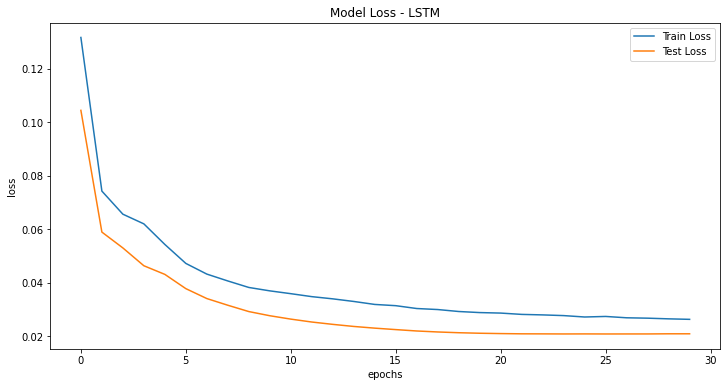

Performance Metrics for - LSTM
Time Execution (s): 9.043439277999994
Train Mean Absolute Error (MAE): 562.29156
Train Root Mean Squared Error (RMSE): 641.35516
Train Mean Absolute Percentage Error (MAPE): 1.1293378
Test Mean Absolute Error (MAE): 383.70096
Test Root Mean Squared Error (RMSE): 499.46805
Test Mean Absolute Percentage Error (MAPE): 0.22006084
----------------


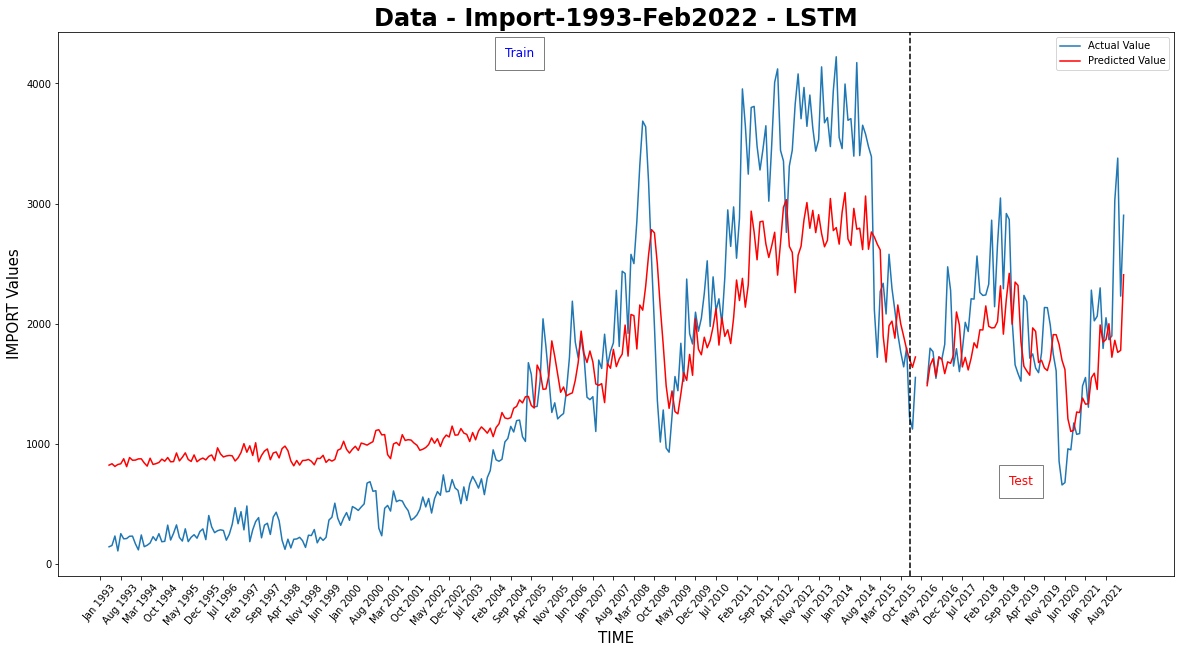

Test MAE: 383.701
Test RMSE: 499.468
Test MAPE: 0.220


In [23]:
# fit the model - LSTM - OilGas
model_lstm, hist_lstm, t1_lstm = get_lstm_result('LSTM', x_trainOG, x_testOG, y_trainOG, y_testOG)
# show the loss function plot
plot_loss(hist_lstm, 'LSTM')
# get the prediction results
tr_pre_lstm, y_tr_lstm, te_pre_lstm, y_te_lstm = get_prediction(model_lstm, x_trainOG, x_testOG, y_trainOG, y_testOG, train_maxOG, train_minOG)
# calculate the errors
mae, rmse, mape = get_errors(tr_pre_lstm, y_tr_lstm, te_pre_lstm, y_te_lstm, t1_lstm, 'LSTM')
# show the prediction plot
pred_plot(tr_pre_lstm, y_tr_lstm, te_pre_lstm, y_te_lstm, 'LSTM')
# report performance
print('Test MAE: %.3f' % (mae))
print('Test RMSE: %.3f' % (rmse))
print('Test MAPE: %.3f' % (mape))

Model Development - GRU
Epoch 1/30
9/9 - 3s - loss: 0.0783 - val_loss: 0.0427 - 3s/epoch - 312ms/step
Epoch 2/30
9/9 - 0s - loss: 0.0596 - val_loss: 0.0366 - 147ms/epoch - 16ms/step
Epoch 3/30
9/9 - 0s - loss: 0.0515 - val_loss: 0.0325 - 154ms/epoch - 17ms/step
Epoch 4/30
9/9 - 0s - loss: 0.0406 - val_loss: 0.0294 - 145ms/epoch - 16ms/step
Epoch 5/30
9/9 - 0s - loss: 0.0344 - val_loss: 0.0256 - 172ms/epoch - 19ms/step
Epoch 6/30
9/9 - 0s - loss: 0.0328 - val_loss: 0.0241 - 159ms/epoch - 18ms/step
Epoch 7/30
9/9 - 0s - loss: 0.0315 - val_loss: 0.0229 - 146ms/epoch - 16ms/step
Epoch 8/30
9/9 - 0s - loss: 0.0300 - val_loss: 0.0219 - 152ms/epoch - 17ms/step
Epoch 9/30
9/9 - 0s - loss: 0.0302 - val_loss: 0.0216 - 150ms/epoch - 17ms/step
Epoch 10/30
9/9 - 0s - loss: 0.0291 - val_loss: 0.0212 - 160ms/epoch - 18ms/step
Epoch 11/30
9/9 - 0s - loss: 0.0286 - val_loss: 0.0211 - 141ms/epoch - 16ms/step
Epoch 12/30
9/9 - 0s - loss: 0.0284 - val_loss: 0.0212 - 144ms/epoch - 16ms/step
Epoch 13/30
9/9

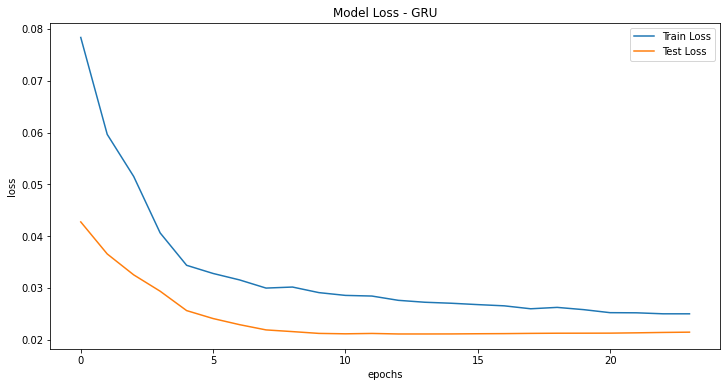

Performance Metrics for - GRU
Time Execution (s): 6.8364466849999985
Train Mean Absolute Error (MAE): 463.5984
Train Root Mean Squared Error (RMSE): 545.6755
Train Mean Absolute Percentage Error (MAPE): 0.86696786
Test Mean Absolute Error (MAE): 380.64853
Test Root Mean Squared Error (RMSE): 497.66223
Test Mean Absolute Percentage Error (MAPE): 0.21912582
----------------


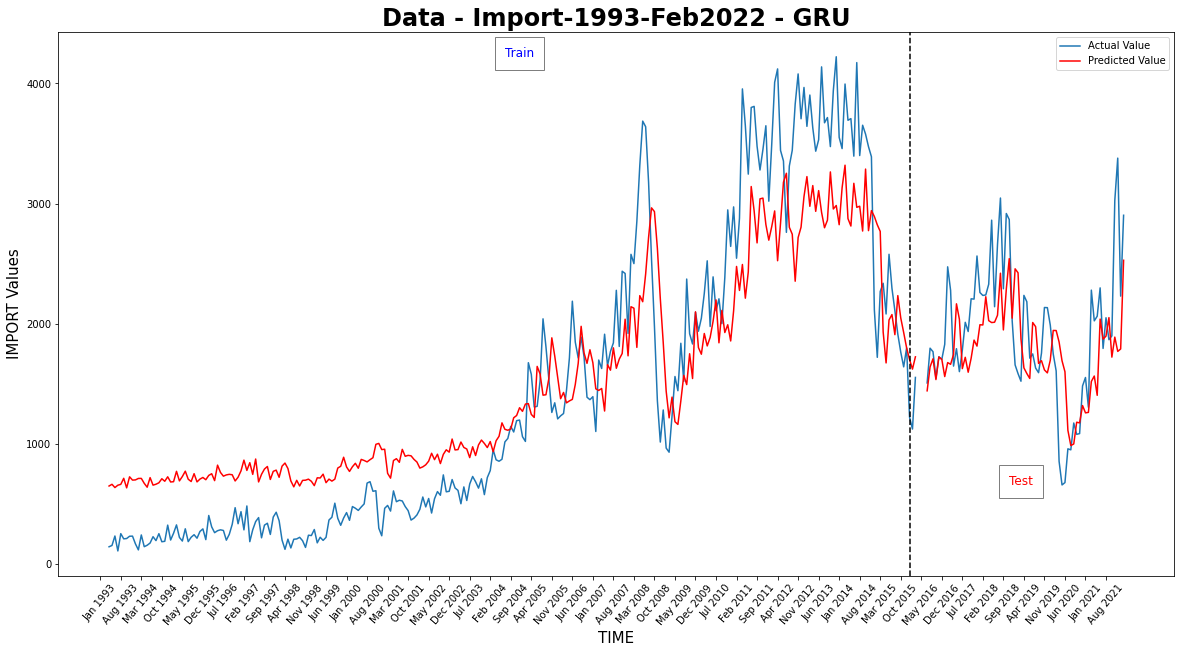

Test MAE: 380.649
Test RMSE: 497.662
Test MAPE: 0.219


In [24]:
# fit the model - GRU - OilGas
model_gru, hist_gru, t1_gru = get_gru_result('GRU', x_trainOG, x_testOG, y_trainOG, y_testOG)
# show the loss function plot
plot_loss(hist_gru, 'GRU')
# get the prediction results
tr_pre_gru, y_tr_gru, te_pre_gru, y_te_gru = get_prediction(model_gru, x_trainOG, x_testOG, y_trainOG, y_testOG, train_maxOG, train_minOG)
# calculate the errors
mae, rmse, mape = get_errors(tr_pre_gru, y_tr_gru, te_pre_gru, y_te_gru, t1_gru, 'GRU')
# show the prediction plot
pred_plot(tr_pre_gru, y_tr_gru, te_pre_gru, y_te_gru, 'GRU')
# report performance
print('Test MAE: %.3f' % (mae))
print('Test RMSE: %.3f' % (rmse))
print('Test MAPE: %.3f' % (mape))

Model Development - LSTM - AFs: tanh and sigmoid
Epoch 1/30
9/9 - 3s - loss: 0.1455 - val_loss: 0.5261 - 3s/epoch - 321ms/step
Epoch 2/30
9/9 - 0s - loss: 0.0827 - val_loss: 0.3139 - 172ms/epoch - 19ms/step
Epoch 3/30
9/9 - 0s - loss: 0.0660 - val_loss: 0.2357 - 172ms/epoch - 19ms/step
Epoch 4/30
9/9 - 0s - loss: 0.0630 - val_loss: 0.2154 - 168ms/epoch - 19ms/step
Epoch 5/30
9/9 - 0s - loss: 0.0537 - val_loss: 0.2027 - 171ms/epoch - 19ms/step
Epoch 6/30
9/9 - 0s - loss: 0.0453 - val_loss: 0.1740 - 157ms/epoch - 17ms/step
Epoch 7/30
9/9 - 0s - loss: 0.0410 - val_loss: 0.1530 - 171ms/epoch - 19ms/step
Epoch 8/30
9/9 - 0s - loss: 0.0380 - val_loss: 0.1374 - 185ms/epoch - 21ms/step
Epoch 9/30
9/9 - 0s - loss: 0.0359 - val_loss: 0.1239 - 164ms/epoch - 18ms/step
Epoch 10/30
9/9 - 0s - loss: 0.0342 - val_loss: 0.1143 - 156ms/epoch - 17ms/step
Epoch 11/30
9/9 - 0s - loss: 0.0329 - val_loss: 0.1065 - 162ms/epoch - 18ms/step
Epoch 12/30
9/9 - 0s - loss: 0.0316 - val_loss: 0.1003 - 163ms/epoch - 

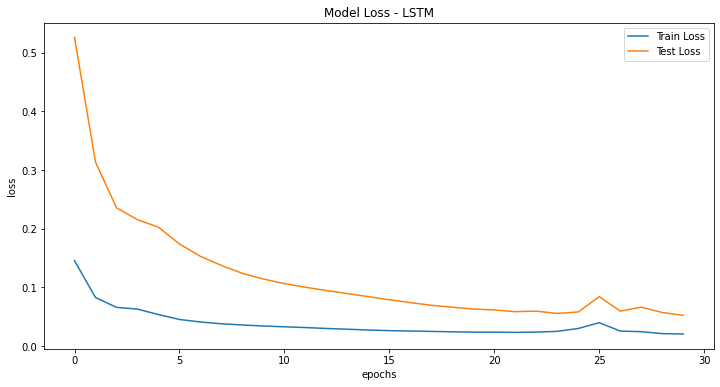

Performance Metrics for - LSTM
Time Execution (s): 8.323306365000008
Train Mean Absolute Error (MAE): 1562.6276
Train Root Mean Squared Error (RMSE): 1746.8936
Train Mean Absolute Percentage Error (MAPE): 0.43778732
Test Mean Absolute Error (MAE): 2805.2363
Test Root Mean Squared Error (RMSE): 3169.9937
Test Mean Absolute Percentage Error (MAPE): 0.21957032
----------------


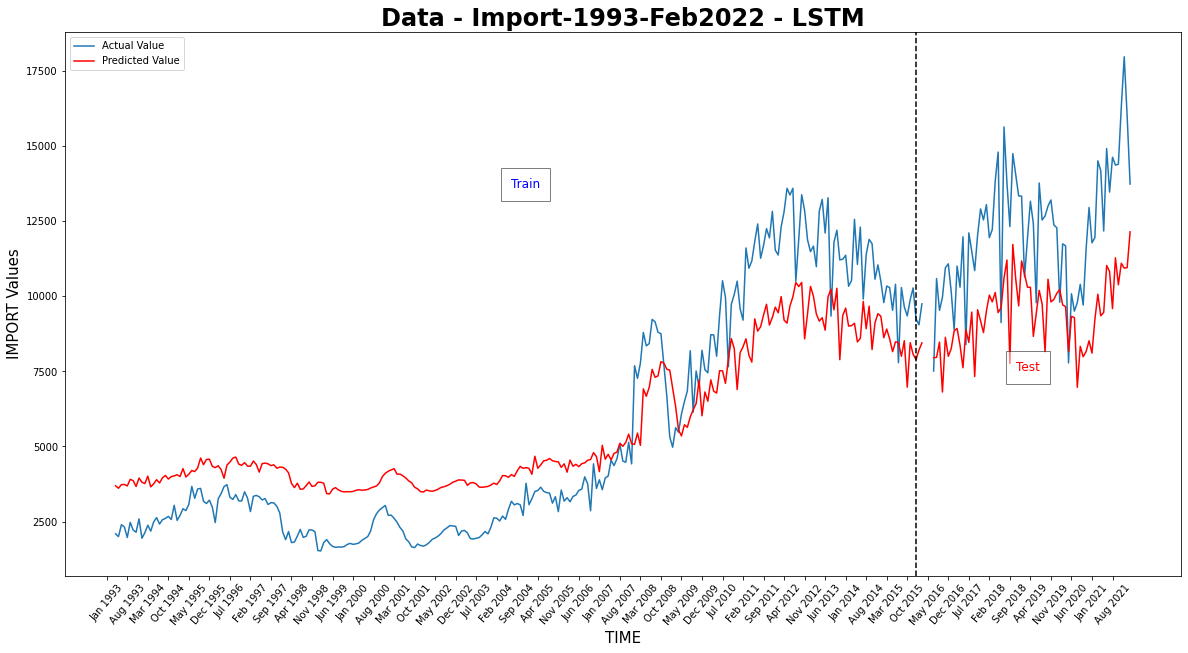

Test MAE: 2805.236
Test RMSE: 3169.994
Test MAPE: 0.220


In [25]:
# fit the model - LSTM - NonOilGas
model_lstm, hist_lstm, t1_lstm = get_lstm_result('LSTM', x_trainNOG, x_testNOG, y_trainNOG, y_testNOG)
# show the loss function plot
plot_loss(hist_lstm, 'LSTM')
# get the prediction results
tr_pre_lstm, y_tr_lstm, te_pre_lstm, y_te_lstm = get_prediction(model_lstm, x_trainNOG, x_testNOG, y_trainNOG, y_testNOG, train_maxNOG, train_minNOG)
# calculate the errors
mae, rmse, mape = get_errors(tr_pre_lstm, y_tr_lstm, te_pre_lstm, y_te_lstm, t1_lstm, 'LSTM')
# show the prediction plot
pred_plot(tr_pre_lstm, y_tr_lstm, te_pre_lstm, y_te_lstm, 'LSTM')
# report performance
print('Test MAE: %.3f' % (mae))
print('Test RMSE: %.3f' % (rmse))
print('Test MAPE: %.3f' % (mape))

Model Development - GRU
Epoch 1/30
9/9 - 3s - loss: 0.0813 - val_loss: 0.2447 - 3s/epoch - 315ms/step
Epoch 2/30
9/9 - 0s - loss: 0.0535 - val_loss: 0.1515 - 162ms/epoch - 18ms/step
Epoch 3/30
9/9 - 0s - loss: 0.0469 - val_loss: 0.1425 - 145ms/epoch - 16ms/step
Epoch 4/30
9/9 - 0s - loss: 0.0350 - val_loss: 0.1183 - 145ms/epoch - 16ms/step
Epoch 5/30
9/9 - 0s - loss: 0.0290 - val_loss: 0.0939 - 141ms/epoch - 16ms/step
Epoch 6/30
9/9 - 0s - loss: 0.0273 - val_loss: 0.0828 - 145ms/epoch - 16ms/step
Epoch 7/30
9/9 - 0s - loss: 0.0257 - val_loss: 0.0738 - 144ms/epoch - 16ms/step
Epoch 8/30
9/9 - 0s - loss: 0.0248 - val_loss: 0.0678 - 159ms/epoch - 18ms/step
Epoch 9/30
9/9 - 0s - loss: 0.0241 - val_loss: 0.0644 - 151ms/epoch - 17ms/step
Epoch 10/30
9/9 - 0s - loss: 0.0231 - val_loss: 0.0609 - 140ms/epoch - 16ms/step
Epoch 11/30
9/9 - 0s - loss: 0.0227 - val_loss: 0.0585 - 139ms/epoch - 15ms/step
Epoch 12/30
9/9 - 0s - loss: 0.0220 - val_loss: 0.0558 - 158ms/epoch - 18ms/step
Epoch 13/30
9/9

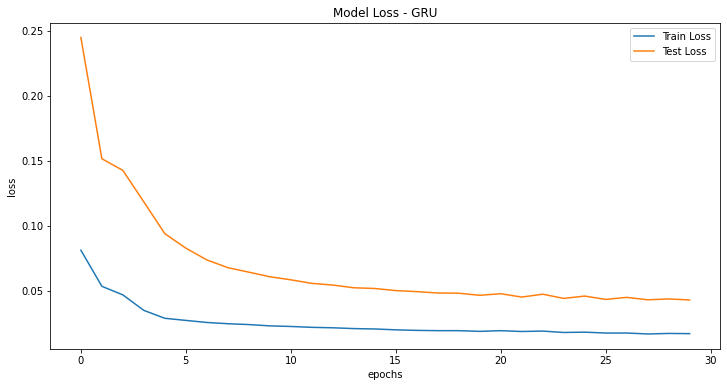

Performance Metrics for - GRU
Time Execution (s): 12.732268552999983
Train Mean Absolute Error (MAE): 842.26544
Train Root Mean Squared Error (RMSE): 1065.1614
Train Mean Absolute Percentage Error (MAPE): 0.22389154
Test Mean Absolute Error (MAE): 1720.7144
Test Root Mean Squared Error (RMSE): 2036.3378
Test Mean Absolute Percentage Error (MAPE): 0.1407794
----------------


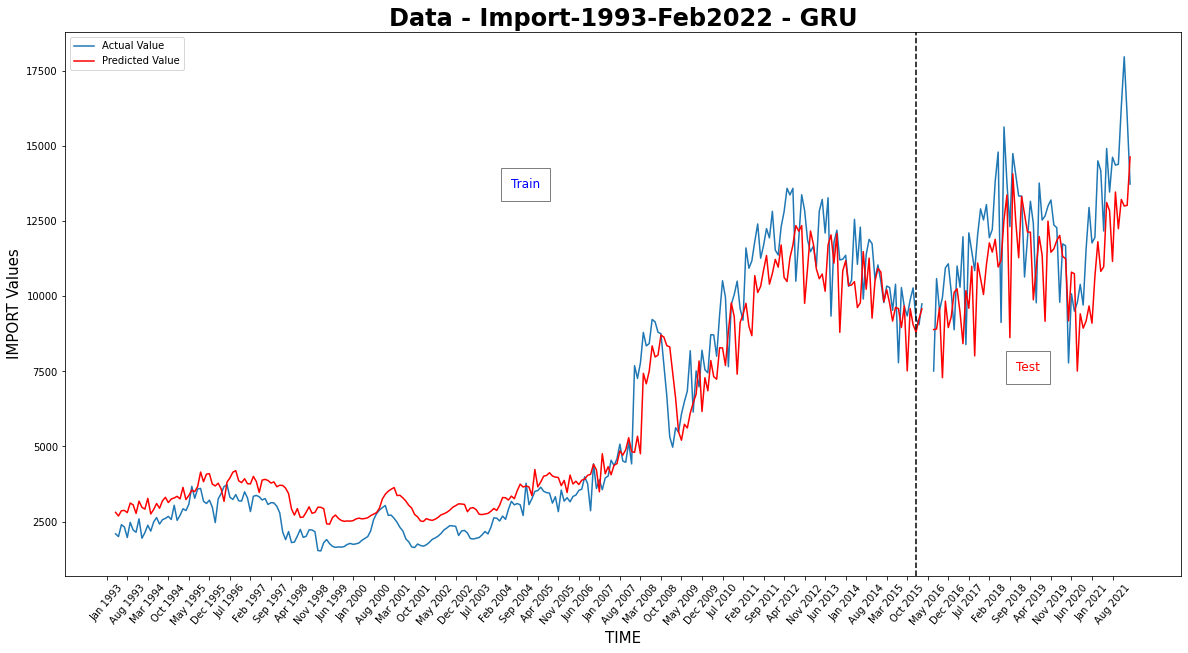

Test MAE: 1720.714
Test RMSE: 2036.338
Test MAPE: 0.141


In [26]:
# fit the model - GRU - NonOilGas
model_gru, hist_gru, t1_gru = get_gru_result('GRU', x_trainNOG, x_testNOG, y_trainNOG, y_testNOG)
# show the loss function plot
plot_loss(hist_gru, 'GRU')
# get the prediction results
tr_pre_gru, y_tr_gru, te_pre_gru, y_te_gru = get_prediction(model_gru, x_trainNOG, x_testNOG, y_trainNOG, y_testNOG, train_maxNOG, train_minNOG)
# calculate the errors
mae, rmse, mape = get_errors(tr_pre_gru, y_tr_gru, te_pre_gru, y_te_gru, t1_gru, 'GRU')
# show the prediction plot
pred_plot(tr_pre_gru, y_tr_gru, te_pre_gru, y_te_gru, 'GRU')
# report performance
print('Test MAE: %.3f' % (mae))
print('Test RMSE: %.3f' % (rmse))
print('Test MAPE: %.3f' % (mape))

# WMA Effect

In [27]:
# Weighted Moving Average
def WMA(src, period):
    wma = [None] * len(src)
    wts = np.array([i+1 for i in reversed(range(period))])
    for i in range(len(src)-period+1):
        wma[i+period-1] = np.average(list(reversed(src[i:(i+period)])), weights = wts)
    return wma

In [28]:
# we will separate the data based on the types
oilGas = data.iloc[:,0]
nOilGas = data.iloc[:,1]

# show the processed data length
print("Data length for Oil and Gas: {} - for Non-Oil and Gas: {}".format(len(oilGas), len(nOilGas)))

Data length for Oil and Gas: 350 - for Non-Oil and Gas: 350


In [29]:
# INPUT WMA period
period = 4

wOG = WMA(oilGas, period)
wNOG = WMA(nOilGas, period)

print(*wOG)

None None None 134.85 142.22000000000003 178.91 158.07 195.18 204.12 208.54000000000002 222.66 224.91 203.43 166.16000000000003 188.07 169.87 165.20999999999998 169.13000000000002 188.41 196.05 221.76 210.95 200.55999999999997 247.89000000000001 232.68 245.44 278.78 256.79 233.0 250.81 222.26 222.18 230.39000000000001 221.65000000000003 243.18999999999997 264.93 243.91 307.39 314.07000000000005 297.59000000000003 290.74000000000007 279.46999999999997 277.97 247.15 241.98000000000002 272.98999999999995 355.08 364.77000000000004 400.98 357.71000000000004 398.56 319.14 294.2 311.7 335.48999999999995 301.64 306.75 314.37 286.11 329.83000000000004 372.16999999999996 375.61 312.42 223.12999999999997 194.57 159.18 175.43 192.03 205.42 205.94 178.07 197.6 213.04000000000002 247.0 227.28999999999996 222.36999999999998 208.74 209.23000000000002 273.96 328.97 414.10999999999996 417.9200000000001 382.59000000000003 375.92999999999995 387.91 381.96999999999997 423.6 444.07000000000005 449.079999999

In [30]:
oilGas = wOG
nOilGas = wNOG

In [31]:
# show the training and test set length
trainOG = oilGas[0:-math.floor(testSize*len(oilGas)+1)]
testOG = oilGas[-(len(oilGas)-len(trainOG)):]
print("Oil and Gas - Training set length: {}    Test set length: {}".format(len(trainOG), len(testOG)))

trainNOG = nOilGas[0:-math.floor(testSize*len(nOilGas)+1)]
testNOG = nOilGas[-(len(nOilGas)-len(trainNOG)):]
print("Non-Oil and Gas - Training set length: {}    Test set length: {}".format(len(trainNOG), len(testNOG)))

Oil and Gas - Training set length: 279    Test set length: 71
Non-Oil and Gas - Training set length: 279    Test set length: 71


In [32]:
# convert the data types to panda Series
trainOG = pd.Series(trainOG)
testOG = pd.Series(testOG)
trainNOG = pd.Series(trainNOG)
testNOG = pd.Series(testNOG)

In [33]:
# <<INPUT>> look_back or how many last steps will be used in the prediction
look_back = 3

# Feature Scaling
train_maxOG = trainOG.max()
train_minOG = trainOG.min()

# Normalize the dataframes
trainOG = (trainOG - train_minOG) / (train_maxOG - train_minOG)
testOG = (testOG - train_minOG) / (train_maxOG - train_minOG)

# Feature Scaling
train_maxNOG = trainNOG.max()
train_minNOG = trainNOG.min()

# Normalize the dataframes
trainNOG = (trainNOG - train_minNOG) / (train_maxNOG - train_minNOG)
testNOG = (testNOG - train_minNOG) / (train_maxNOG - train_minNOG)

In [34]:
# create the processed training and test set
x_trainOG, y_trainOG = create_dataset(trainOG, look_back)
x_testOG, y_testOG = create_dataset(testOG, look_back)

# reshape input data to be [samples, time steps, features]
x_trainOG = np.reshape(x_trainOG, (x_trainOG.shape[0], x_trainOG.shape[1], 1))
x_testOG = np.reshape(x_testOG, (x_testOG.shape[0], x_testOG.shape[1], 1))

print(len(x_trainOG), len(y_trainOG), len(x_testOG), len(y_testOG))
print(x_trainOG.shape, y_trainOG.shape, x_testOG.shape, y_testOG.shape)

# create the processed training and test set
x_trainNOG, y_trainNOG = create_dataset(trainNOG, look_back)
x_testNOG, y_testNOG = create_dataset(testNOG, look_back)

# reshape input data to be [samples, time steps, features]
x_trainNOG = np.reshape(x_trainNOG, (x_trainNOG.shape[0], x_trainNOG.shape[1], 1))
x_testNOG = np.reshape(x_testNOG, (x_testNOG.shape[0], x_testNOG.shape[1], 1))

print(len(x_trainNOG), len(y_trainNOG), len(x_testNOG), len(y_testNOG))
print(x_trainNOG.shape, y_trainNOG.shape, x_testNOG.shape, y_testNOG.shape)

276 276 68 68
(276, 3, 1) (276,) (68, 3, 1) (68,)
276 276 68 68
(276, 3, 1) (276,) (68, 3, 1) (68,)


In [35]:
# replace nan with 0 - simple imputation
x_trainOG = np.where(np.isnan(x_trainOG), 0, x_trainOG)
x_trainNOG = np.where(np.isnan(x_trainNOG), 0, x_trainNOG)

#print(x_trainOG)

Model Development - w-LSTM - AFs: tanh and sigmoid
Epoch 1/30
9/9 - 3s - loss: 0.1330 - val_loss: 0.0984 - 3s/epoch - 366ms/step
Epoch 2/30
9/9 - 0s - loss: 0.0743 - val_loss: 0.0588 - 171ms/epoch - 19ms/step
Epoch 3/30
9/9 - 0s - loss: 0.0709 - val_loss: 0.0532 - 184ms/epoch - 20ms/step
Epoch 4/30
9/9 - 0s - loss: 0.0640 - val_loss: 0.0466 - 192ms/epoch - 21ms/step
Epoch 5/30
9/9 - 0s - loss: 0.0556 - val_loss: 0.0420 - 167ms/epoch - 19ms/step
Epoch 6/30
9/9 - 0s - loss: 0.0483 - val_loss: 0.0362 - 171ms/epoch - 19ms/step
Epoch 7/30
9/9 - 0s - loss: 0.0448 - val_loss: 0.0324 - 164ms/epoch - 18ms/step
Epoch 8/30
9/9 - 0s - loss: 0.0417 - val_loss: 0.0296 - 154ms/epoch - 17ms/step
Epoch 9/30
9/9 - 0s - loss: 0.0390 - val_loss: 0.0272 - 153ms/epoch - 17ms/step
Epoch 10/30
9/9 - 0s - loss: 0.0377 - val_loss: 0.0256 - 178ms/epoch - 20ms/step
Epoch 11/30
9/9 - 0s - loss: 0.0363 - val_loss: 0.0242 - 161ms/epoch - 18ms/step
Epoch 12/30
9/9 - 0s - loss: 0.0355 - val_loss: 0.0231 - 174ms/epoch 

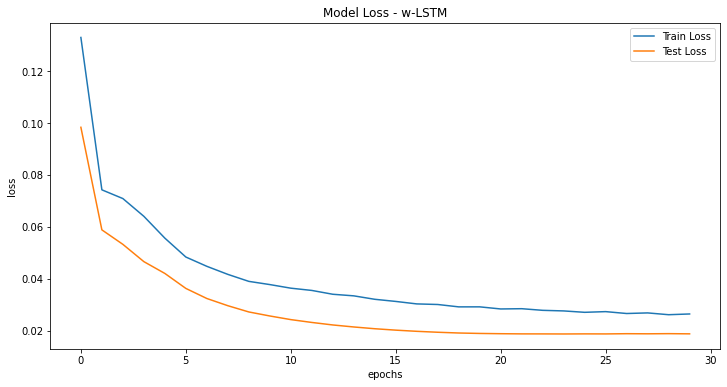

Performance Metrics for - w-LSTM
Time Execution (s): 8.75531184099998
Train Mean Absolute Error (MAE): 485.78058
Train Root Mean Squared Error (RMSE): 543.1941
Train Mean Absolute Percentage Error (MAPE): 0.9585345
Test Mean Absolute Error (MAE): 310.05286
Test Root Mean Squared Error (RMSE): 389.9897
Test Mean Absolute Percentage Error (MAPE): 0.17567255
----------------


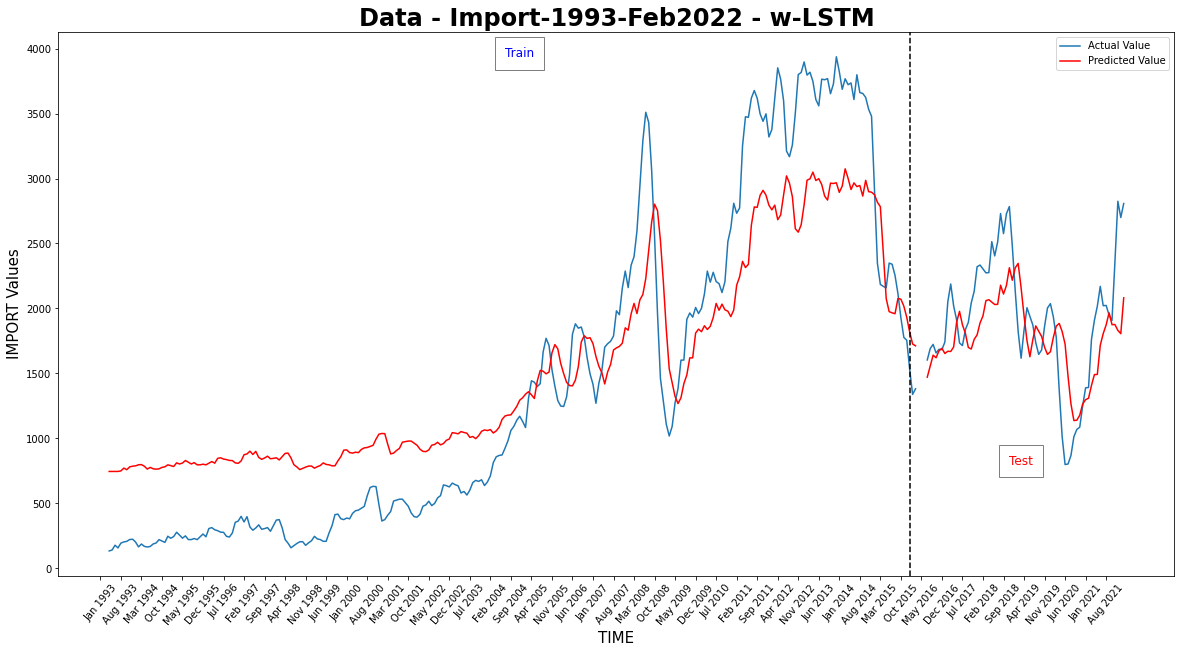

Test MAE: 310.053
Test RMSE: 389.990
Test MAPE: 0.176


In [36]:
# fit the model - w-LSTM - OilGas
model_lstm, hist_lstm, t1_lstm = get_lstm_result('w-LSTM', x_trainOG, x_testOG, y_trainOG, y_testOG)
# show the loss function plot
plot_loss(hist_lstm, 'w-LSTM')
# get the prediction results
tr_pre_lstm, y_tr_lstm, te_pre_lstm, y_te_lstm = get_prediction(model_lstm, x_trainOG, x_testOG, y_trainOG, y_testOG, train_maxOG, train_minOG)
# calculate the errors
mae, rmse, mape = get_errors(tr_pre_lstm, y_tr_lstm, te_pre_lstm, y_te_lstm, t1_lstm, 'w-LSTM')
# show the prediction plot
pred_plot(tr_pre_lstm, y_tr_lstm, te_pre_lstm, y_te_lstm, 'w-LSTM')
# report performance
print('Test MAE: %.3f' % (mae))
print('Test RMSE: %.3f' % (rmse))
print('Test MAPE: %.3f' % (mape))

Model Development - w-GRU
Epoch 1/30
9/9 - 3s - loss: 0.0959 - val_loss: 0.0475 - 3s/epoch - 317ms/step
Epoch 2/30
9/9 - 0s - loss: 0.0653 - val_loss: 0.0395 - 175ms/epoch - 19ms/step
Epoch 3/30
9/9 - 0s - loss: 0.0584 - val_loss: 0.0322 - 142ms/epoch - 16ms/step
Epoch 4/30
9/9 - 0s - loss: 0.0459 - val_loss: 0.0301 - 137ms/epoch - 15ms/step
Epoch 5/30
9/9 - 0s - loss: 0.0375 - val_loss: 0.0251 - 143ms/epoch - 16ms/step
Epoch 6/30
9/9 - 0s - loss: 0.0353 - val_loss: 0.0230 - 152ms/epoch - 17ms/step
Epoch 7/30
9/9 - 0s - loss: 0.0338 - val_loss: 0.0218 - 151ms/epoch - 17ms/step
Epoch 8/30
9/9 - 0s - loss: 0.0322 - val_loss: 0.0204 - 164ms/epoch - 18ms/step
Epoch 9/30
9/9 - 0s - loss: 0.0314 - val_loss: 0.0198 - 171ms/epoch - 19ms/step
Epoch 10/30
9/9 - 0s - loss: 0.0307 - val_loss: 0.0194 - 155ms/epoch - 17ms/step
Epoch 11/30
9/9 - 0s - loss: 0.0300 - val_loss: 0.0192 - 155ms/epoch - 17ms/step
Epoch 12/30
9/9 - 0s - loss: 0.0294 - val_loss: 0.0191 - 144ms/epoch - 16ms/step
Epoch 13/30
9

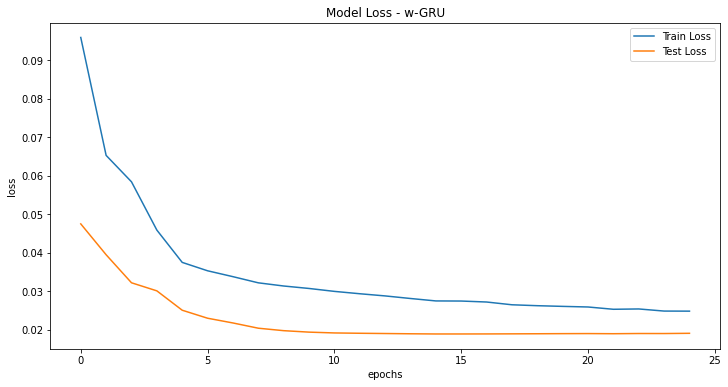

Performance Metrics for - w-GRU
Time Execution (s): 7.037053672000013
Train Mean Absolute Error (MAE): 402.8973
Train Root Mean Squared Error (RMSE): 459.54773
Train Mean Absolute Percentage Error (MAPE): 0.7483344
Test Mean Absolute Error (MAE): 305.1575
Test Root Mean Squared Error (RMSE): 384.3101
Test Mean Absolute Percentage Error (MAPE): 0.17317481
----------------


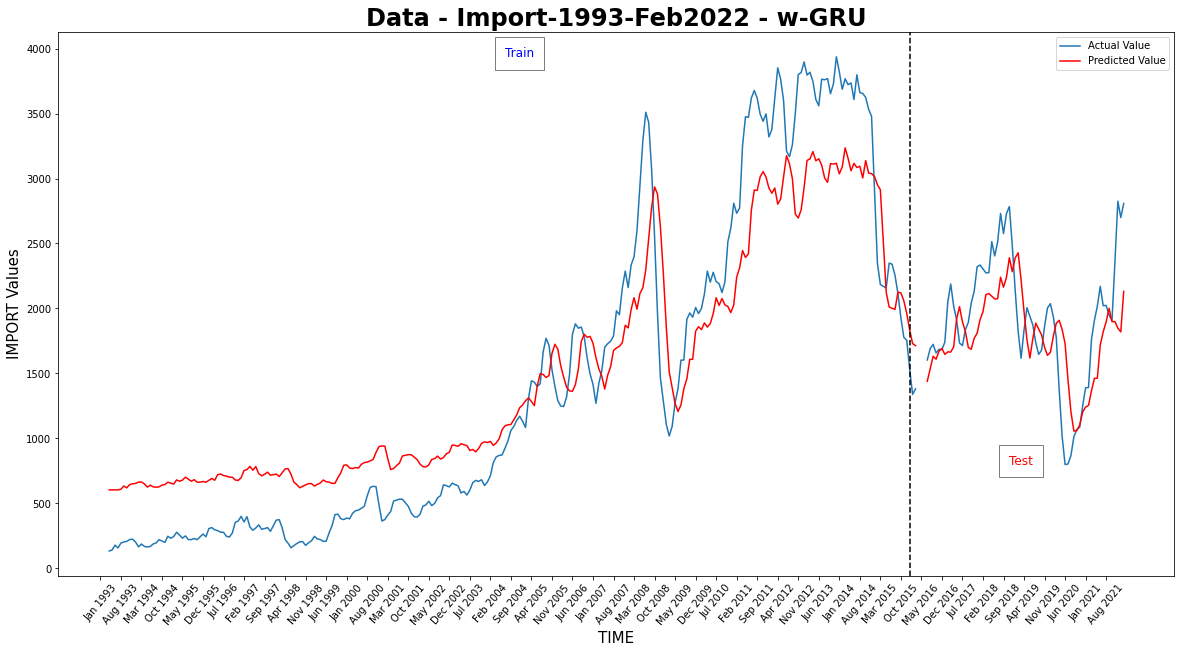

Test MAE: 305.158
Test RMSE: 384.310
Test MAPE: 0.173


In [37]:
# fit the model - w-GRU - OilGas
model_gru, hist_gru, t1_gru = get_gru_result('w-GRU', x_trainOG, x_testOG, y_trainOG, y_testOG)
# show the loss function plot
plot_loss(hist_gru, 'w-GRU')
# get the prediction results
tr_pre_gru, y_tr_gru, te_pre_gru, y_te_gru = get_prediction(model_gru, x_trainOG, x_testOG, y_trainOG, y_testOG, train_maxOG, train_minOG)
# calculate the errors
mae, rmse, mape = get_errors(tr_pre_gru, y_tr_gru, te_pre_gru, y_te_gru, t1_gru, 'w-GRU')
# show the prediction plot
pred_plot(tr_pre_gru, y_tr_gru, te_pre_gru, y_te_gru, 'w-GRU')
# report performance
print('Test MAE: %.3f' % (mae))
print('Test RMSE: %.3f' % (rmse))
print('Test MAPE: %.3f' % (mape))

Model Development - w-LSTM - AFs: tanh and sigmoid
Epoch 1/30
9/9 - 3s - loss: 0.1254 - val_loss: 0.4474 - 3s/epoch - 311ms/step
Epoch 2/30
9/9 - 0s - loss: 0.0711 - val_loss: 0.2620 - 169ms/epoch - 19ms/step
Epoch 3/30
9/9 - 0s - loss: 0.0635 - val_loss: 0.2097 - 154ms/epoch - 17ms/step
Epoch 4/30
9/9 - 0s - loss: 0.0582 - val_loss: 0.1974 - 156ms/epoch - 17ms/step
Epoch 5/30
9/9 - 0s - loss: 0.0492 - val_loss: 0.1809 - 154ms/epoch - 17ms/step
Epoch 6/30
9/9 - 0s - loss: 0.0415 - val_loss: 0.1518 - 154ms/epoch - 17ms/step
Epoch 7/30
9/9 - 0s - loss: 0.0377 - val_loss: 0.1327 - 155ms/epoch - 17ms/step
Epoch 8/30
9/9 - 0s - loss: 0.0350 - val_loss: 0.1175 - 159ms/epoch - 18ms/step
Epoch 9/30
9/9 - 0s - loss: 0.0326 - val_loss: 0.1050 - 161ms/epoch - 18ms/step
Epoch 10/30
9/9 - 0s - loss: 0.0316 - val_loss: 0.0965 - 157ms/epoch - 17ms/step
Epoch 11/30
9/9 - 0s - loss: 0.0303 - val_loss: 0.0895 - 170ms/epoch - 19ms/step
Epoch 12/30
9/9 - 0s - loss: 0.0298 - val_loss: 0.0844 - 153ms/epoch 

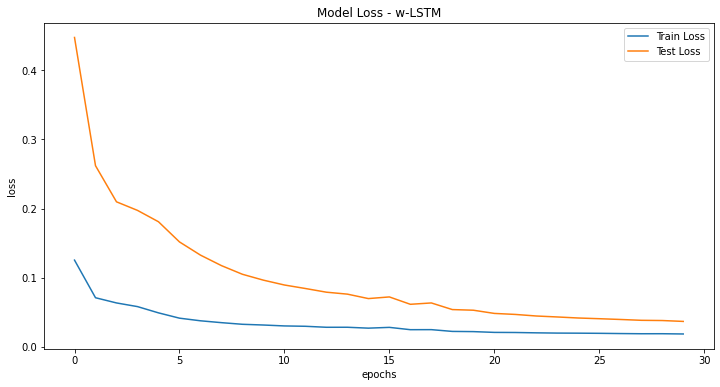

Performance Metrics for - w-LSTM
Time Execution (s): 12.632214035999937
Train Mean Absolute Error (MAE): 1376.7498
Train Root Mean Squared Error (RMSE): 1467.9152
Train Mean Absolute Percentage Error (MAPE): 0.4102913
Test Mean Absolute Error (MAE): 2155.905
Test Root Mean Squared Error (RMSE): 2380.8179
Test Mean Absolute Percentage Error (MAPE): 0.1720102
----------------


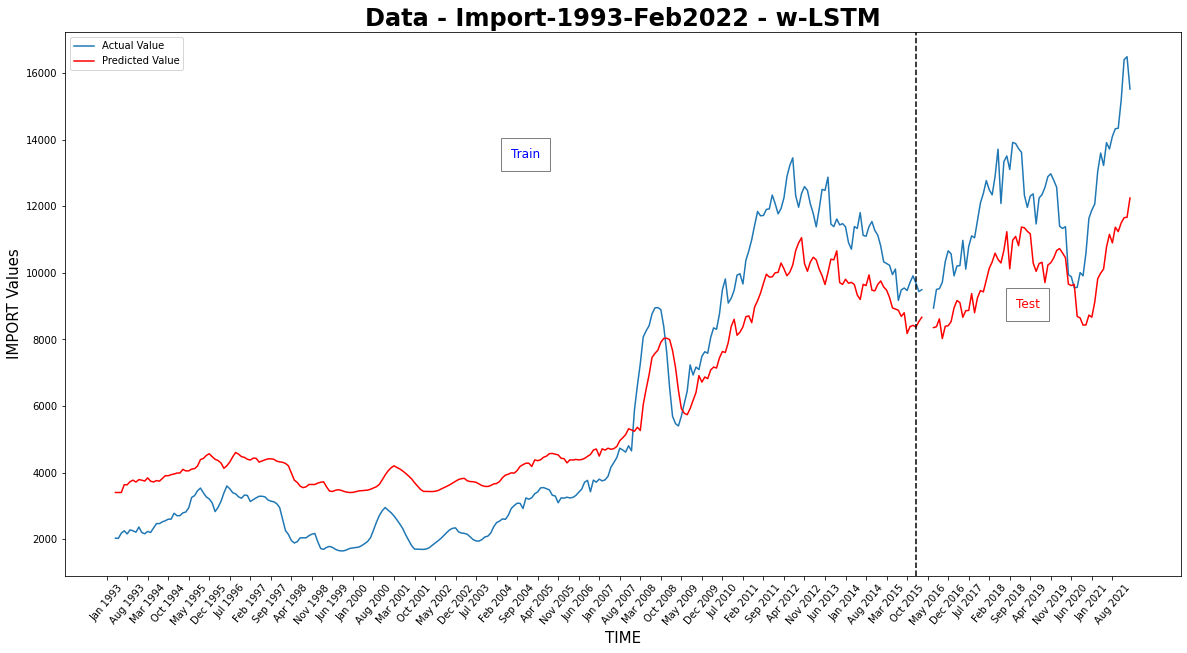

Test MAE: 2155.905
Test RMSE: 2380.818
Test MAPE: 0.172


In [38]:
# fit the model - w-LSTM - NonOilGas
model_lstm, hist_lstm, t1_lstm = get_lstm_result('w-LSTM', x_trainNOG, x_testNOG, y_trainNOG, y_testNOG)
# show the loss function plot
plot_loss(hist_lstm, 'w-LSTM')
# get the prediction results
tr_pre_lstm, y_tr_lstm, te_pre_lstm, y_te_lstm = get_prediction(model_lstm, x_trainNOG, x_testNOG, y_trainNOG, y_testNOG, train_maxNOG, train_minNOG)
# calculate the errors
mae, rmse, mape = get_errors(tr_pre_lstm, y_tr_lstm, te_pre_lstm, y_te_lstm, t1_lstm, 'w-LSTM')
# show the prediction plot
pred_plot(tr_pre_lstm, y_tr_lstm, te_pre_lstm, y_te_lstm, 'w-LSTM')
# report performance
print('Test MAE: %.3f' % (mae))
print('Test RMSE: %.3f' % (rmse))
print('Test MAPE: %.3f' % (mape))

Model Development - w-GRU
Epoch 1/30
9/9 - 3s - loss: 0.0771 - val_loss: 0.2272 - 3s/epoch - 320ms/step
Epoch 2/30
9/9 - 0s - loss: 0.0523 - val_loss: 0.1423 - 151ms/epoch - 17ms/step
Epoch 3/30
9/9 - 0s - loss: 0.0443 - val_loss: 0.1347 - 148ms/epoch - 16ms/step
Epoch 4/30
9/9 - 0s - loss: 0.0332 - val_loss: 0.1075 - 149ms/epoch - 17ms/step
Epoch 5/30
9/9 - 0s - loss: 0.0278 - val_loss: 0.0834 - 147ms/epoch - 16ms/step
Epoch 6/30
9/9 - 0s - loss: 0.0259 - val_loss: 0.0720 - 154ms/epoch - 17ms/step
Epoch 7/30
9/9 - 0s - loss: 0.0242 - val_loss: 0.0628 - 146ms/epoch - 16ms/step
Epoch 8/30
9/9 - 0s - loss: 0.0234 - val_loss: 0.0566 - 156ms/epoch - 17ms/step
Epoch 9/30
9/9 - 0s - loss: 0.0226 - val_loss: 0.0531 - 141ms/epoch - 16ms/step
Epoch 10/30
9/9 - 0s - loss: 0.0216 - val_loss: 0.0494 - 141ms/epoch - 16ms/step
Epoch 11/30
9/9 - 0s - loss: 0.0209 - val_loss: 0.0465 - 142ms/epoch - 16ms/step
Epoch 12/30
9/9 - 0s - loss: 0.0202 - val_loss: 0.0438 - 154ms/epoch - 17ms/step
Epoch 13/30
9

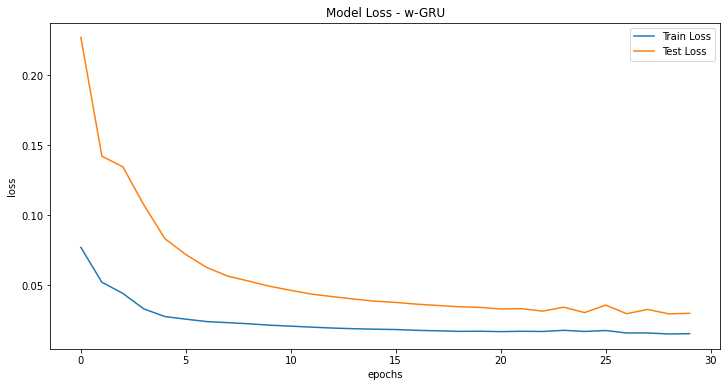

Performance Metrics for - w-GRU
Time Execution (s): 12.65005393599995
Train Mean Absolute Error (MAE): 639.5878
Train Root Mean Squared Error (RMSE): 785.3341
Train Mean Absolute Percentage Error (MAPE): 0.17541075
Test Mean Absolute Error (MAE): 1224.9948
Test Root Mean Squared Error (RMSE): 1417.8495
Test Mean Absolute Percentage Error (MAPE): 0.09793585
----------------


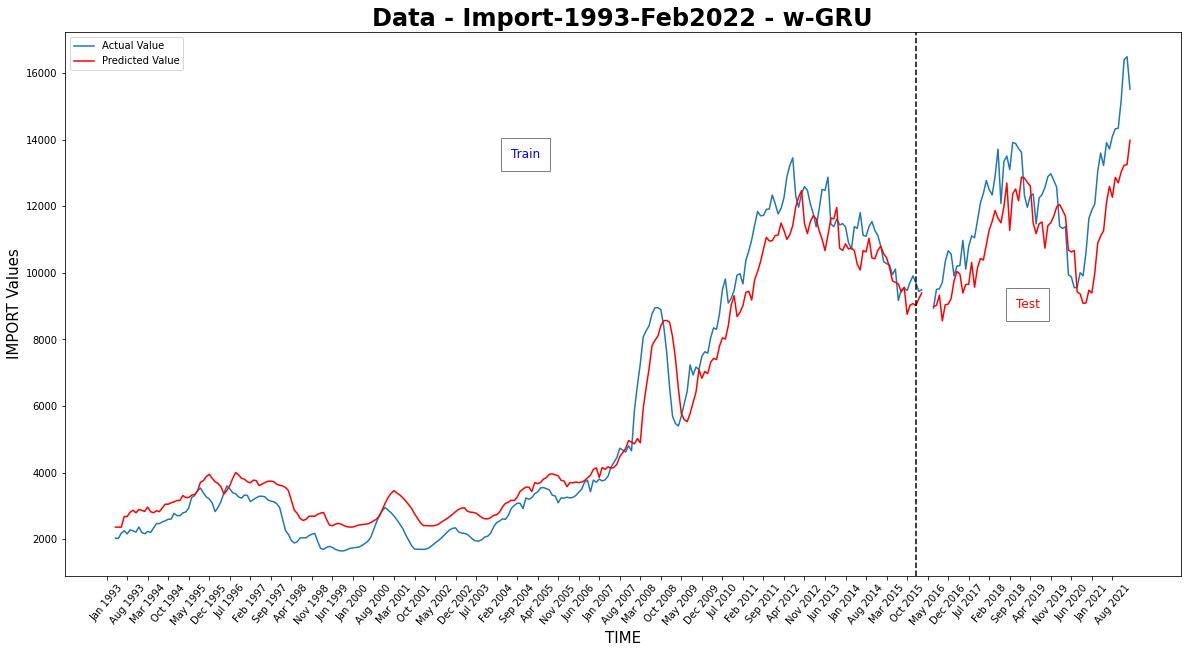

Test MAE: 1224.995
Test RMSE: 1417.849
Test MAPE: 0.098


In [39]:
# fit the model - w-GRU - NonOilGas
model_gru, hist_gru, t1_gru = get_gru_result('w-GRU', x_trainNOG, x_testNOG, y_trainNOG, y_testNOG)
# show the loss function plot
plot_loss(hist_gru, 'w-GRU')
# get the prediction results
tr_pre_gru, y_tr_gru, te_pre_gru, y_te_gru = get_prediction(model_gru, x_trainNOG, x_testNOG, y_trainNOG, y_testNOG, train_maxNOG, train_minNOG)
# calculate the errors
mae, rmse, mape = get_errors(tr_pre_gru, y_tr_gru, te_pre_gru, y_te_gru, t1_gru, 'w-GRU')
# show the prediction plot
pred_plot(tr_pre_gru, y_tr_gru, te_pre_gru, y_te_gru, 'w-GRU')
# report performance
print('Test MAE: %.3f' % (mae))
print('Test RMSE: %.3f' % (rmse))
print('Test MAPE: %.3f' % (mape))